In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')

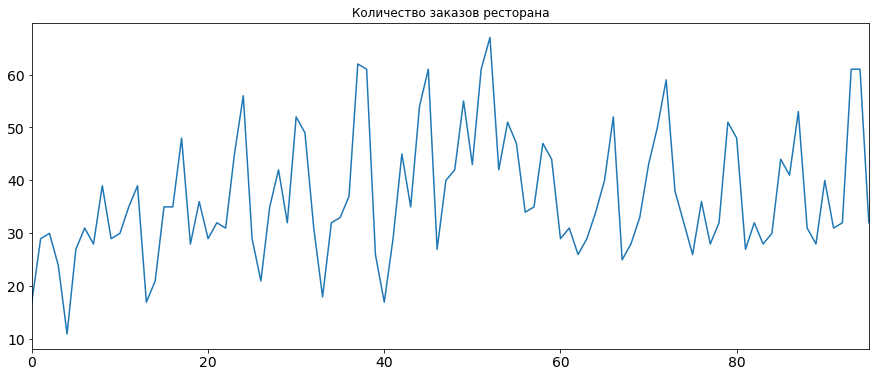

In [4]:
train.orders.plot( figsize=(15,6),title= 'Количество заказов ресторана', fontsize=14)

In [5]:
train['orders_log_01'] = np.log(np.log(train.orders))

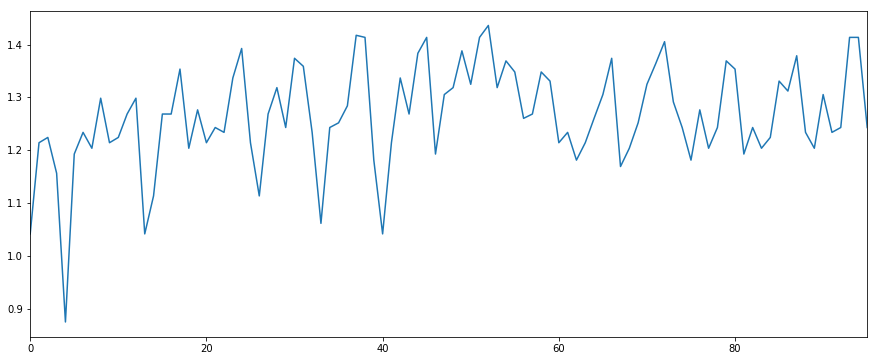

In [6]:
train.orders_log_01.plot(figsize=(15, 6))

In [7]:
train['orders_log_diff'] = train.orders_log_01 - train.orders_log_01.shift(1)
train.orders_log_diff[0] = 0

/home/svasilyev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


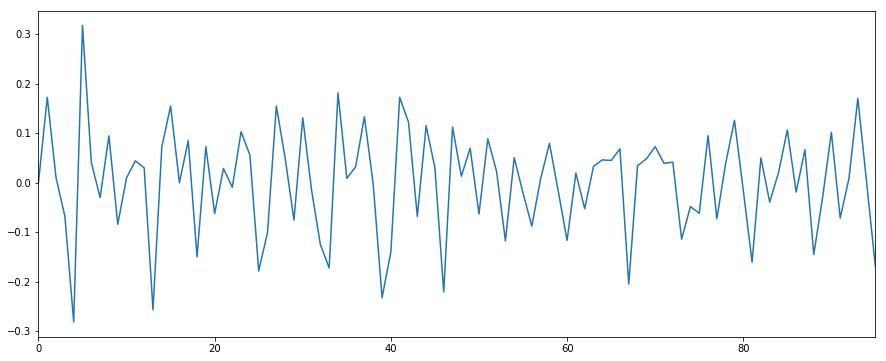

In [8]:
train.orders_log_diff.plot(figsize=(15, 6))

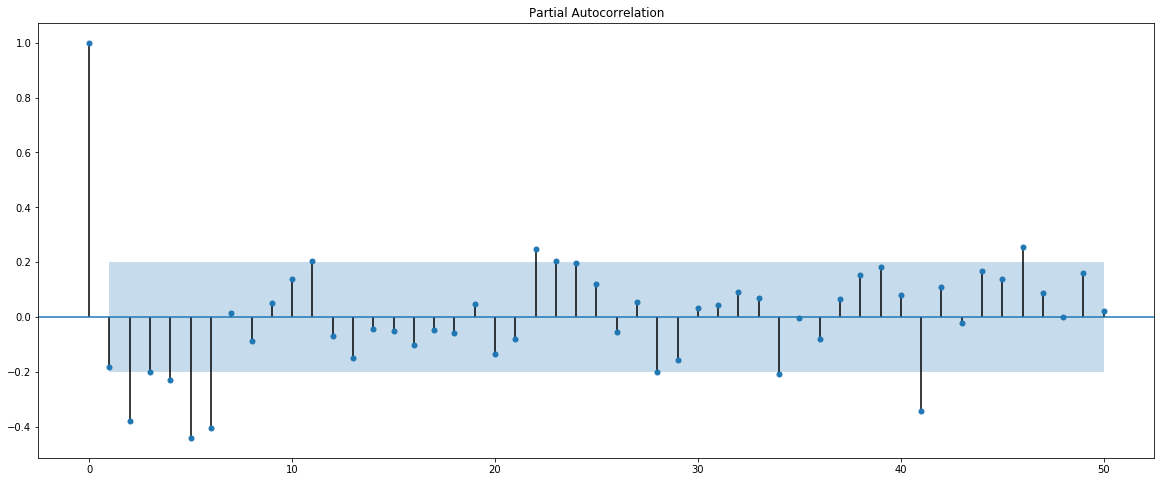

In [9]:
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_pacf(train.orders_log_diff.values, lags=50,ax = ax)
plt.show()

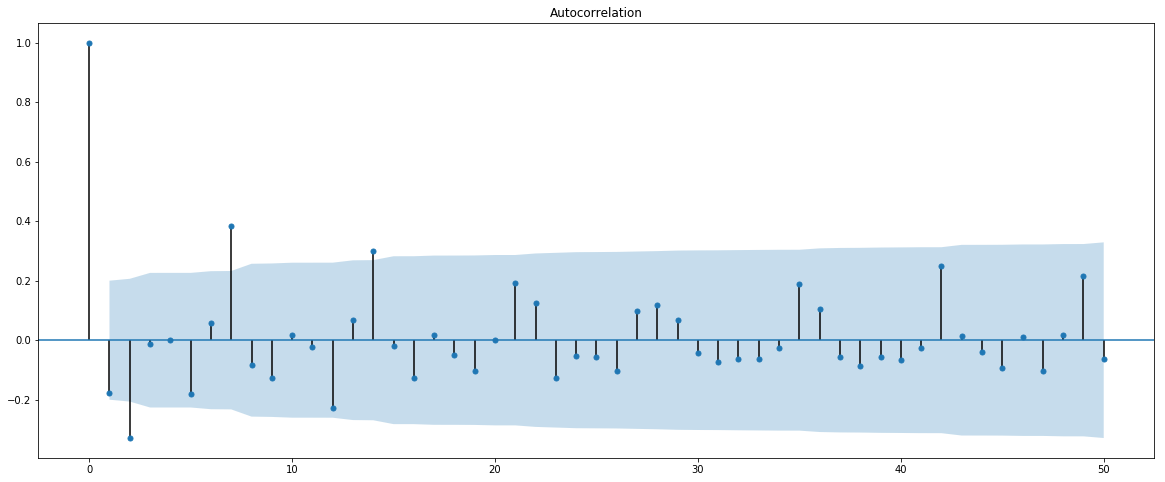

In [10]:
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(train.orders_log_diff.values, lags=50,ax = ax)
plt.show()

In [11]:
ps = range(0, 2)
d = 2
qs = range(0, 2)
Ps = range(0, 2)
D = 0
Qs = range(0, 2)

In [12]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [13]:
import warnings
results = []
best_model = None
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train.orders_log_01, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        print(param)
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 0)
(0, 1, 1, 1)


In [14]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                
Dep. Variable:                     orders_log_01   No. Observations:                   96
Model:             SARIMAX(0, 2, 1)x(1, 0, 1, 7)   Log Likelihood                  86.344
Date:                           Wed, 24 Apr 2019   AIC                           -164.688
Time:                                   10:54:40   BIC                           -154.514
Sample:                                        0   HQIC                          -160.578
                                            - 96                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      1.582     -0.632      0.527      -4.101       2.101
ar.S.L7        0.9990      0.036     27.740

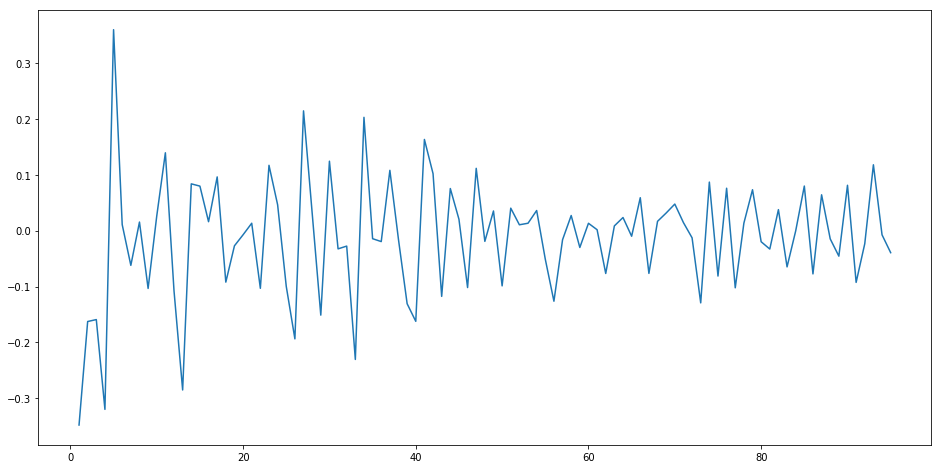

In [15]:
# Остатки модели
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[1:])
plt.show()

In [16]:
stat_test = sm.tsa.adfuller(best_model.resid[:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.133220601203566
p-value:  3.474122947030265e-10
Critical values:  {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}
единичных корней нет, ряд стационарен


In [17]:
forecast = best_model.predict(start = train.shape[0] - 20, end = train.shape[0])

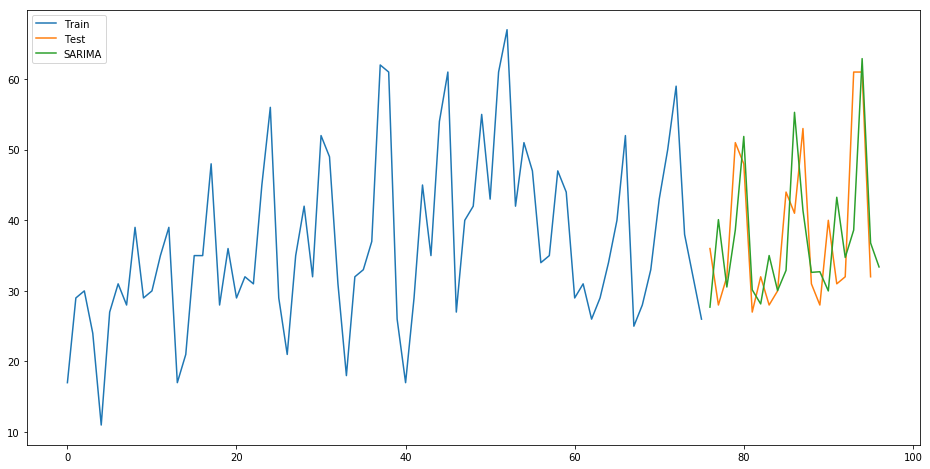

In [18]:
plt.figure(figsize=(16,8))
plt.plot(train.orders[:-20], label='Train')
plt.plot(train.orders[-20:], label='Test')
plt.plot(np.exp(np.exp(forecast)), label='SARIMA')
plt.legend(loc='best')
plt.show()

In [19]:
test = pd.read_csv('test.csv')

In [21]:
forecast1 = np.exp(np.exp(best_model.predict(start = train.shape[0], end = train.shape[0] + test.shape[0] - 1)))

In [24]:
a = test.drop(['date'], axis=1)

In [25]:
a['orders'] = forecast1.values

In [26]:
a

,date_id,orders
0,97,33.393632
1,98,36.677974
2,99,38.620169
3,100,43.335032
4,101,54.909451
5,102,56.446906
6,103,34.052248
7,104,35.561145


In [27]:
a.to_csv('sub.csv', index=False)

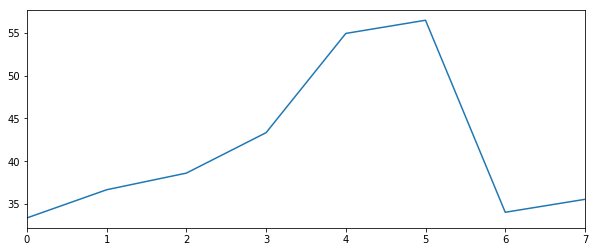

In [28]:
a.orders.plot(figsize=(10, 4))